In [74]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
df = pd.read_csv("./dsfa.csv")

In [4]:
df = df[~df.SecuCode.isin([600196, 600837, 600875, 600839, 600739,
                           600795, 2])]

In [5]:
NUMBER_ASSETS = 50

select stocks with top50 avg. trading volume and number of dates == 3871

In [6]:
secuCount = df.SecuCode.value_counts()

In [7]:
df_1 = df[df.SecuCode.isin(secuCount[secuCount == 3871].index)]

In [8]:
select_secuCode = df_1.groupby("SecuCode").dvol.mean().sort_values().index[-(10+NUMBER_ASSETS):]

In [9]:
df_1

,SecuCode,SecuAbbr,date,prc,oprc,high,low,svol,dvol,Adjfac,ret,day_ret,TotalShares,float,totcap,indcode
0,1,平安银行,2000-01-04,18.29,17.50,18.55,17.20,8216086.0,1.473254e+08,20.43190,NaN,0.045143,1.551847e+09,1.960019e+10,2.838328e+10,480000.0
1,69,华侨城Ａ,2000-01-04,8.53,8.33,8.54,8.20,321052.0,2.707183e+06,1.80477,NaN,0.024010,3.456000e+08,7.677000e+08,2.947968e+09,460000.0
2,600753,东方银星,2000-01-04,14.22,13.10,14.22,12.50,1003150.0,1.398014e+07,1.60657,NaN,0.085496,1.280000e+08,4.550400e+08,1.820160e+09,330000.0
3,600112,ST 天 成,2000-01-04,9.49,9.15,9.55,9.15,355777.0,3.348087e+06,1.12325,NaN,0.037158,1.720000e+08,4.934800e+08,1.632280e+09,630000.0
5,600113,浙江东日,2000-01-04,11.49,11.31,11.51,11.20,169188.0,1.925010e+06,1.02513,NaN,0.015915,1.180000e+08,4.596000e+08,1.355820e+09,620000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634111,600075,新疆天业,2015-12-31,10.71,10.98,11.08,10.70,9620472.0,1.049724e+08,7.28232,-0.029012,-0.024590,4.385920e+08,4.697320e+09,4.697320e+09,220000.0
6634113,938,紫光股份,2015-12-31,98.38,104.17,104.80,98.11,6906451.0,7.005191e+08,2.52194,-0.053128,-0.055582,2.060800e+08,2.027415e+10,2.027415e+10,710000.0
6634115,509,*ST 华塑,2015-12-31,8.60,8.78,8.85,8.60,8756977.0,7.613287e+07,10.95070,-0.028249,-0.020501,8.254831e+08,7.099155e+09,7.099155e+09,610000.0
6634116,933,神火股份,2015-12-31,4.98,5.20,5.20,4.94,55380879.0,2.801840e+08,12.01840,-0.045977,-0.042308,1.900500e+09,9.464490e+09,9.464490e+09,210000.0


build ret matrix

In [10]:
ret_df = pd.DataFrame(
    index=df[df.SecuCode.isin(select_secuCode)].date.unique(),
    columns=select_secuCode,
)

In [11]:
for secu in select_secuCode:
    secuRet = df[df.SecuCode==secu][["date", "day_ret"]].set_index("date")
    ret_df[secu] = secuRet["day_ret"]
    
## check if there exists nan value
# ret_df.isna.sum()

In [14]:
ret_df.to_csv("./ret_df.csv")

In [12]:
ret_df = pd.read_csv("./ret_df.csv", index_col=0)

In [67]:
def remove_zero_ret( ret_df ):
    
    keep_columns = ret_df.columns[ret_df.sum(axis=0) != 0]
    ret_df = ret_df[keep_columns].iloc[:,:NUMBER_ASSETS]
    
    return ret_df

In [68]:
def solve_minrisk( cov ):
    omega = np.linalg.inv( cov )
    return np.dot(omega, np.ones(NUMBER_ASSETS))/np.dot( np.ones(NUMBER_ASSETS), 
                          np.dot(omega, np.ones(NUMBER_ASSETS)) )

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal

from fgan import fgan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
def robust_cov( data ):
    
    ret_mat = data.to_numpy()
    # ret_mat.std() returns a single num, noted weight is invariant under scale transformation
    ret_mat = ret_mat / ret_mat.std() 
    ret_mat = torch.from_numpy( ret_mat ).float()
    
    f = fgan(NUMBER_ASSETS, 0.0, device, epsilon=1e-5)
    f.dist_init(true_type='Gaussian', cont_type='Gaussian',
                 t_df=2, c_cov=1.0, c_loc=1.0)
    f.data_init(batch_size=50, data=ret_mat)
    f.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
               init_D='xavier', init_D1=0.025, init_G='kendall',
               activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

    f.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
    f.fit(floss='js', epochs=2000, avg_epochs=50,
      verbose=250, show=False, logd_trick=False)
    
    A = f.netG.weight.data.cpu().numpy()
    cov = np.matmul(A.T, A) * data.to_numpy().std()**2
    
    return cov

In [77]:
def get_sample_cov( data ):
    
    ret_mat = data.to_numpy()
    
    return np.cov(ret_mat, rowvar=False)


In [78]:
def backtest( ret_df, training_window, test_window, covfunc, **kwargs ):
    
    rounds = (len(ret_df) - test_window) // training_window
    groundrisk = []
    minrisk = []
    sp_coverr = []
    fro_coverr = []
    min_coverr = []
    
    for r in range(rounds):
        
        train_ret_df = ret_df.iloc[ (r*training_window):((r+1)*training_window), :NUMBER_ASSETS ]
        train_ret_df = remove_zero_ret( 
            ret_df.iloc[ (r*training_window):((r+1)*training_window)  ] )
        robust_cov_mat = covfunc( data=train_ret_df, **kwargs )
        weight = solve_minrisk( robust_cov_mat )
        
        test_ret_df = ret_df.iloc[ 
            ((r+1)*training_window):((r+1)*training_window+test_window) ][train_ret_df.columns]
        cov_mat = np.cov( test_ret_df.to_numpy(), rowvar=False ) 
        
        minrisk2 = np.dot( weight, 
                         np.dot( cov_mat, weight ))/test_window*252
        minrisk.append( np.sqrt(minrisk2) )
        
        residue_mat = robust_cov_mat - cov_mat
        sp_coverr.append( np.linalg.norm(residue_mat, ord=2) )
        fro_coverr.append( np.linalg.norm(residue_mat, ord='fro') )
        
        _, robust_s, _ = np.linalg.svd( robust_cov_mat )
        _, test_s, _ = np.linalg.svd( cov_mat )
        
        print(r)
        print("RISK:", minrisk)
        print("SP_COVERR:", sp_coverr)
        print("FRO_COVERR", fro_coverr)
        #print("MIN_COVERR", min_coverr)
        print("robust smallest singular value:", robust_s[-1])
        print("test smallest singular value:",test_s[-1])
        
    return groundrisk, minrisk, sp_coverr, fro_coverr, min_coverr

        
        

In [87]:
result_normal = backtest( ret_df, training_window=252, test_window=252, covfunc=get_sample_cov )

0
RISK: [0.01370453740931208]
SP_COVERR: [0.0035368496314269506]
FRO_COVERR [0.005899816153563819]
robust smallest singular value: 8.202712246641915e-05
test smallest singular value: 3.3332970575821236e-05
1
RISK: [0.01370453740931208, 0.007081121198136349]
SP_COVERR: [0.0035368496314269506, 0.003654576283856232]
FRO_COVERR [0.005899816153563819, 0.004014752663066949]
robust smallest singular value: 3.3332970575821236e-05
test smallest singular value: 1.7521313937310457e-05
2
RISK: [0.01370453740931208, 0.007081121198136349, 0.007497421216150873]
SP_COVERR: [0.0035368496314269506, 0.003654576283856232, 0.0023894601263624066]
FRO_COVERR [0.005899816153563819, 0.004014752663066949, 0.0035454168715738743]
robust smallest singular value: 1.7521313937310457e-05
test smallest singular value: 4.152100506485221e-05
3
RISK: [0.01370453740931208, 0.007081121198136349, 0.007497421216150873, 0.022959606715859997]
SP_COVERR: [0.0035368496314269506, 0.003654576283856232, 0.0023894601263624066, 0.004

Epoch:250, LossD/G:1.4090/-0.7271


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


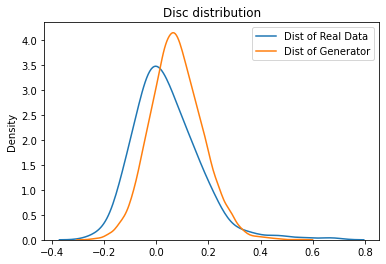

Epoch:500, LossD/G:1.3739/-0.6858


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


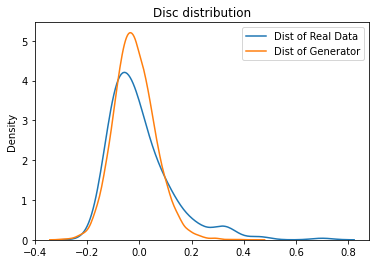

Epoch:750, LossD/G:1.3759/-0.6769


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


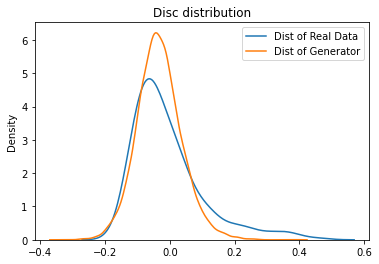

Epoch:1000, LossD/G:1.3777/-0.6789


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


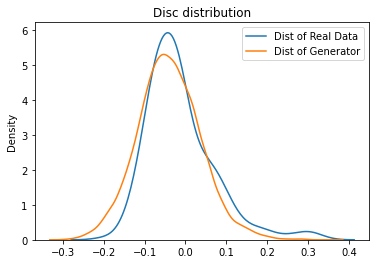

Epoch:1250, LossD/G:1.3570/-0.6585


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


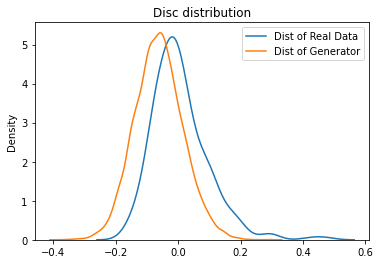

Epoch:1500, LossD/G:1.3427/-0.6680


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


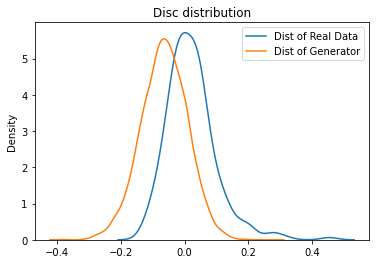

Epoch:1750, LossD/G:1.3462/-0.6674


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


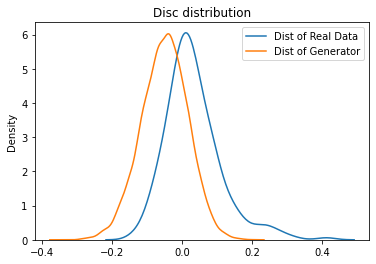

Epoch:2000, LossD/G:1.3383/-0.6647


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


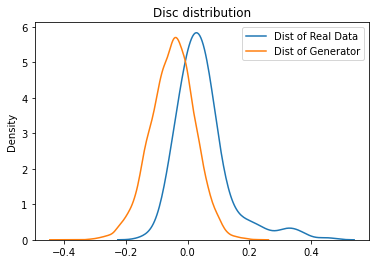

0
RISK: [0.029536766506364196]
SP_COVERR: [0.004708952993082814]
FRO_COVERR [0.007632223164894378]
robust smallest singular value: 1.1747413e-06
test smallest singular value: 3.3332970575821236e-05
Epoch:250, LossD/G:1.3872/-0.6987


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


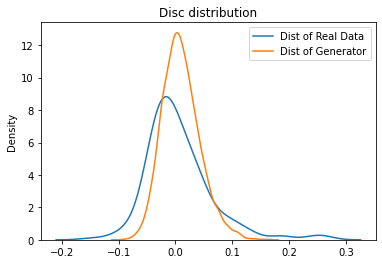

Epoch:500, LossD/G:1.4051/-0.7151


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


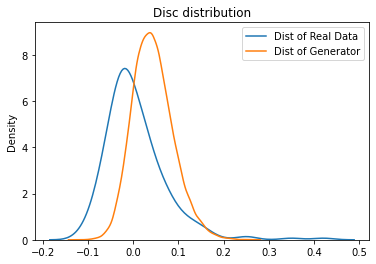

Epoch:750, LossD/G:1.3835/-0.6907


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


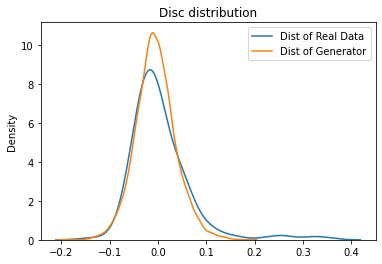

Epoch:1000, LossD/G:1.3967/-0.7027


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


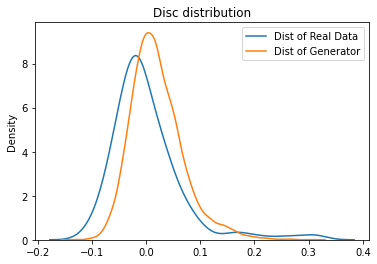

Epoch:1250, LossD/G:1.3836/-0.6846


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


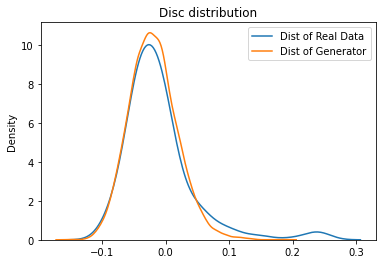

Epoch:1500, LossD/G:1.3842/-0.6847


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


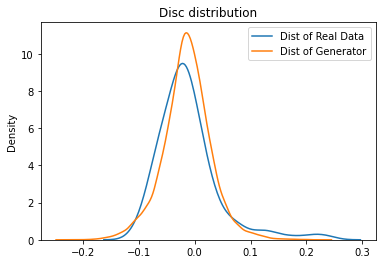

Epoch:1750, LossD/G:1.3806/-0.6761


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


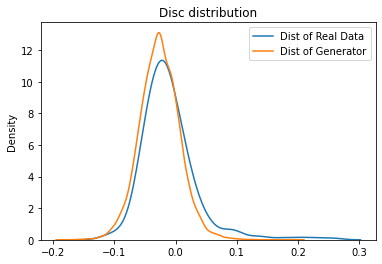

Epoch:2000, LossD/G:1.3738/-0.6834


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


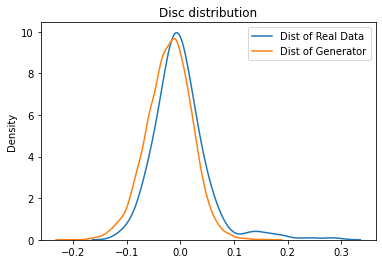

1
RISK: [0.029536766506364196, 0.01570223899727173]
SP_COVERR: [0.004708952993082814, 0.002229374901090403]
FRO_COVERR [0.007632223164894378, 0.003374177365473334]
robust smallest singular value: 6.1557915e-07
test smallest singular value: 1.7521313937310457e-05
Epoch:250, LossD/G:1.3926/-0.6978


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


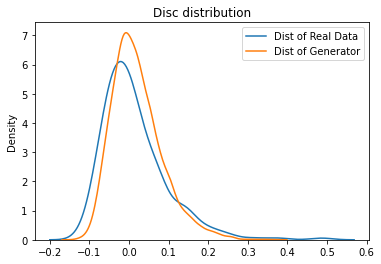

Epoch:500, LossD/G:1.4036/-0.7084


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


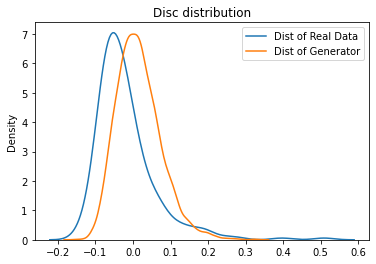

Epoch:750, LossD/G:1.3855/-0.6804


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


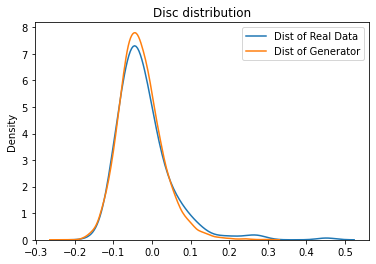

Epoch:1000, LossD/G:1.3927/-0.6861


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


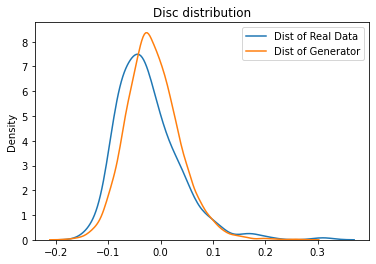

Epoch:1250, LossD/G:1.3799/-0.6730


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


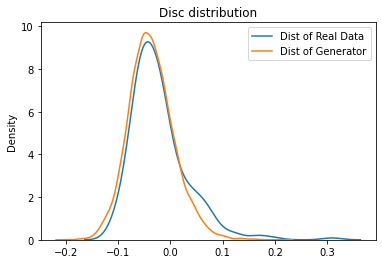

Epoch:1500, LossD/G:1.3785/-0.6750


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


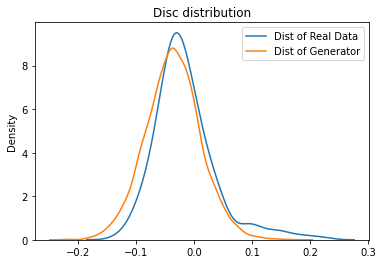

Epoch:1750, LossD/G:1.3735/-0.6792


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


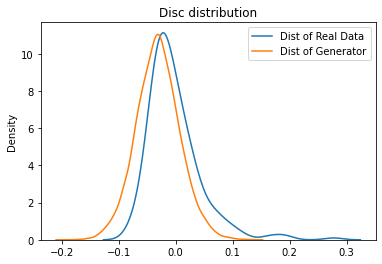

Epoch:2000, LossD/G:1.3724/-0.6831


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


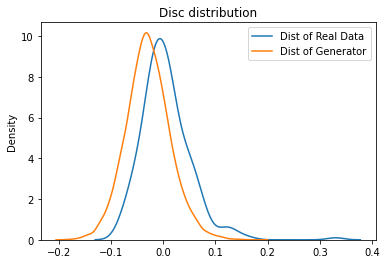

2
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528]
robust smallest singular value: 1.5287917e-06
test smallest singular value: 4.152100506485221e-05
Epoch:250, LossD/G:1.3921/-0.7165


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


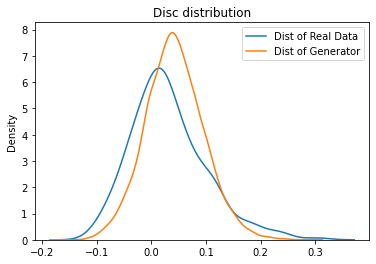

Epoch:500, LossD/G:1.4040/-0.7250


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


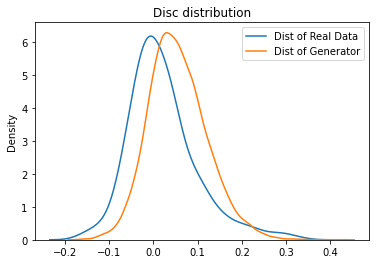

Epoch:750, LossD/G:1.3870/-0.6926


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


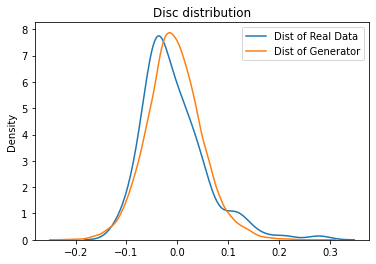

Epoch:1000, LossD/G:1.3929/-0.6994


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


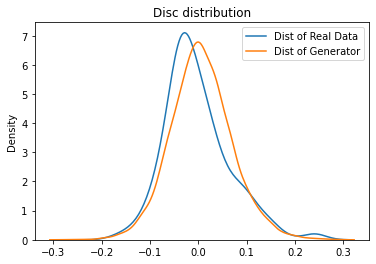

Epoch:1250, LossD/G:1.3844/-0.6850


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


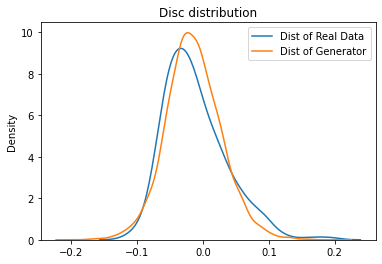

Epoch:1500, LossD/G:1.3756/-0.6771


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


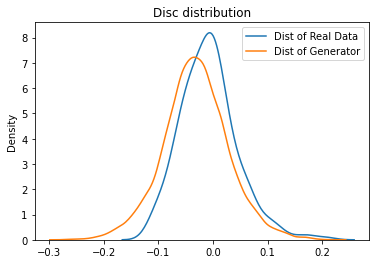

Epoch:1750, LossD/G:1.3790/-0.6855


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


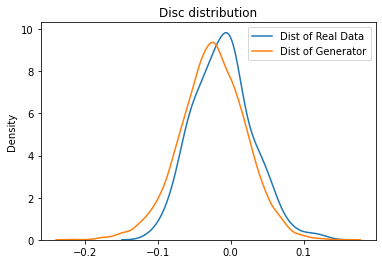

Epoch:2000, LossD/G:1.3600/-0.6700


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


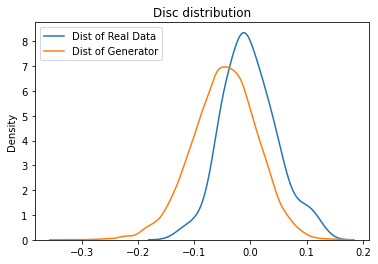

3
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707]
robust smallest singular value: 2.4414942e-06
test smallest singular value: 3.808806669832412e-05
Epoch:250, LossD/G:1.3961/-0.7109


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


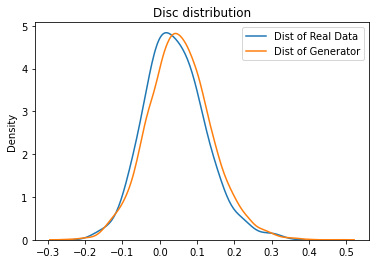

Epoch:500, LossD/G:1.3994/-0.7218


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


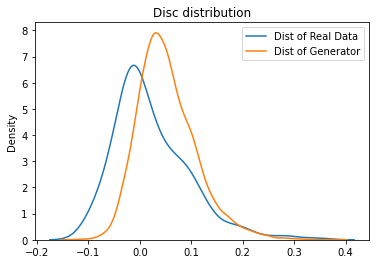

Epoch:750, LossD/G:1.3970/-0.6950


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


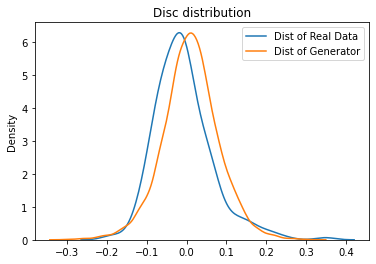

Epoch:1000, LossD/G:1.3847/-0.6765


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


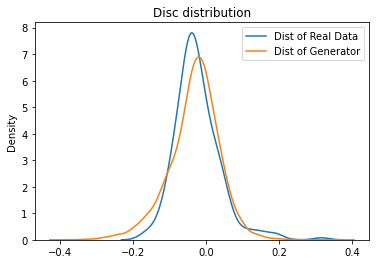

Epoch:1250, LossD/G:1.3881/-0.6869


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


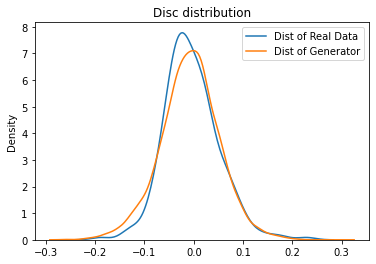

Epoch:1500, LossD/G:1.3767/-0.6765


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


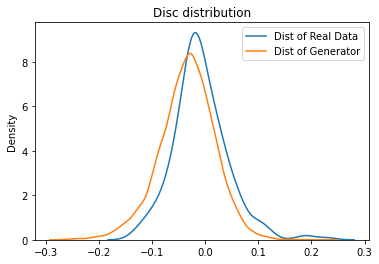

Epoch:1750, LossD/G:1.3803/-0.6822


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


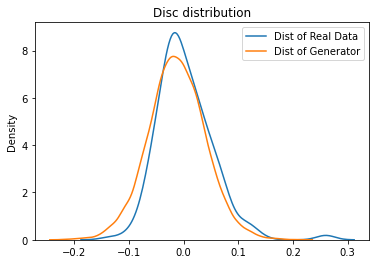

Epoch:2000, LossD/G:1.3657/-0.6773


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


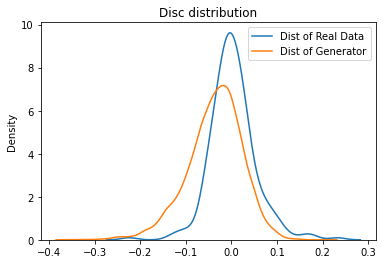

4
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205]
robust smallest singular value: 1.3969681e-06
test smallest singular value: 6.580195926450174e-05
Epoch:250, LossD/G:1.3924/-0.6967


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


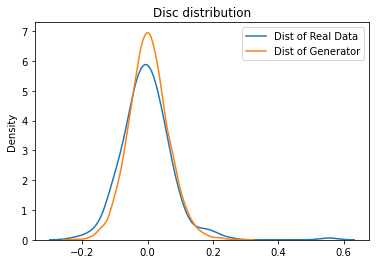

Epoch:500, LossD/G:1.4022/-0.7107


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


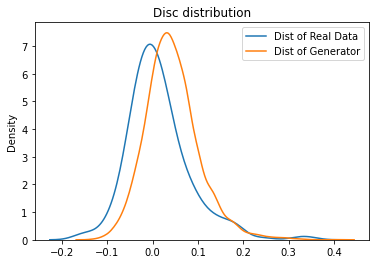

Epoch:750, LossD/G:1.3937/-0.6899


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


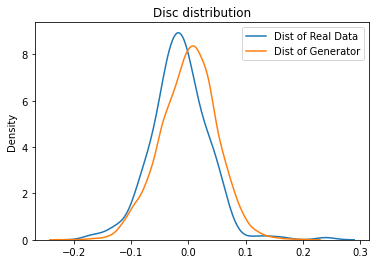

Epoch:1000, LossD/G:1.3867/-0.7003


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


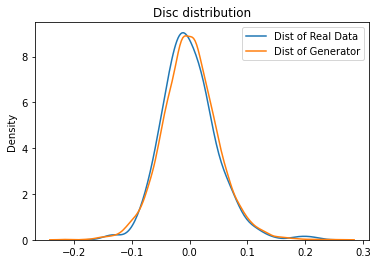

Epoch:1250, LossD/G:1.3920/-0.6952


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


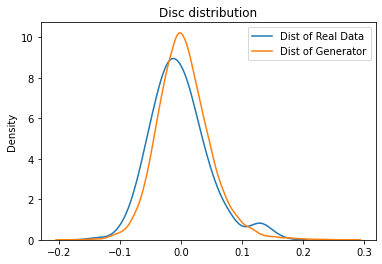

Epoch:1500, LossD/G:1.3743/-0.6853


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


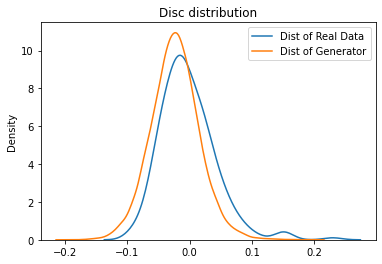

Epoch:1750, LossD/G:1.3836/-0.6873


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


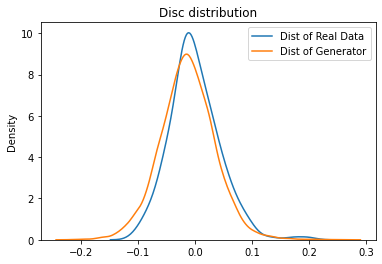

Epoch:2000, LossD/G:1.3833/-0.6849


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


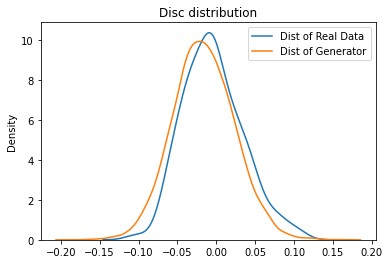

5
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192]
robust smallest singular value: 1.3925755e-06
test smallest singular value: 0.00011111054234489152
Epoch:250, LossD/G:1.3879/-0.7006


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


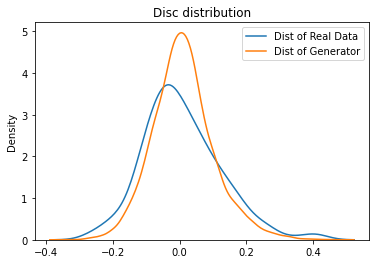

Epoch:500, LossD/G:1.3857/-0.7018


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


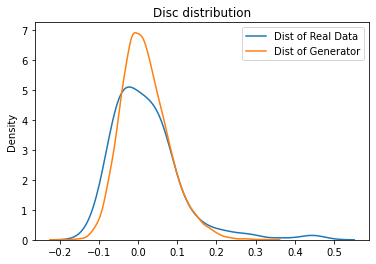

Epoch:750, LossD/G:1.3965/-0.6948


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


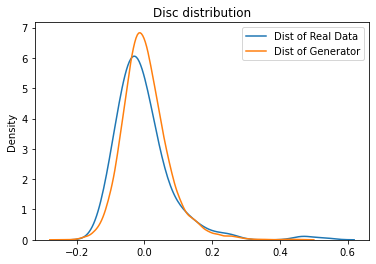

Epoch:1000, LossD/G:1.3715/-0.6730


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


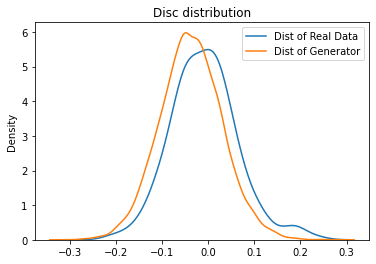

Epoch:1250, LossD/G:1.3677/-0.6752


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


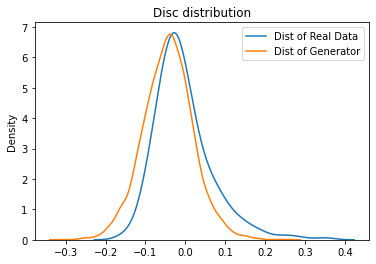

Epoch:1500, LossD/G:1.3613/-0.6713


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


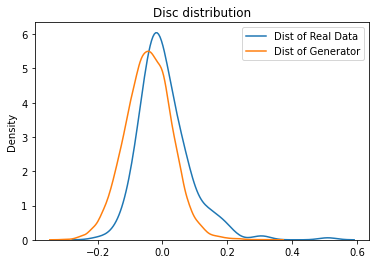

Epoch:1750, LossD/G:1.3575/-0.6728


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


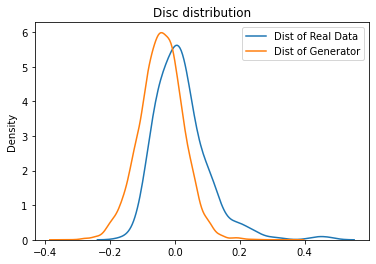

Epoch:2000, LossD/G:1.3637/-0.6722


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


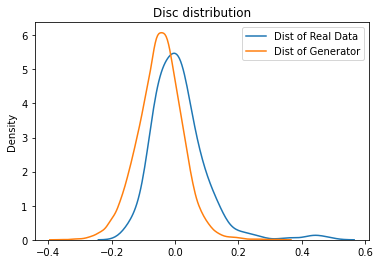

6
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276]
robust smallest singular value: 1.9919692e-07
test smallest singular value: 3.5593607201745736e-18
Epoch:250, LossD/G:1.3743/-0.6998


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


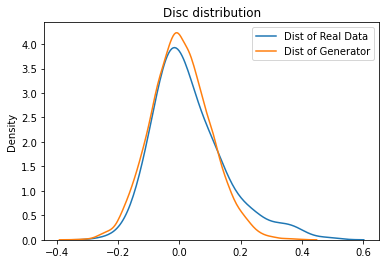

Epoch:500, LossD/G:1.3943/-0.6803


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


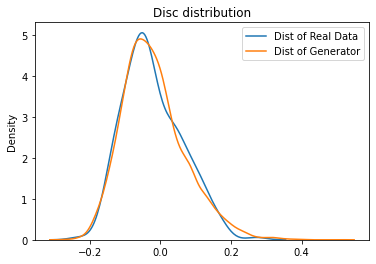

Epoch:750, LossD/G:1.3944/-0.6895


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


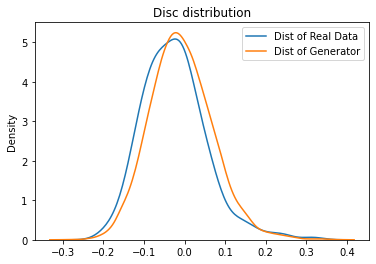

Epoch:1000, LossD/G:1.3702/-0.6759


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


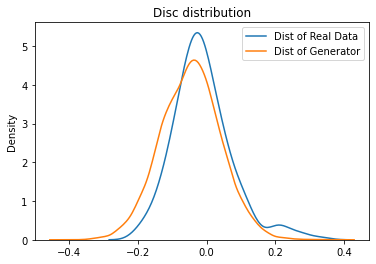

Epoch:1250, LossD/G:1.3711/-0.6645


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


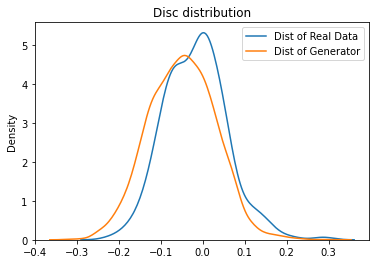

Epoch:1500, LossD/G:1.3711/-0.6814


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


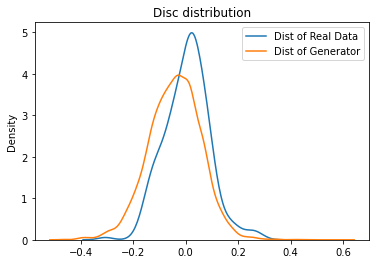

Epoch:1750, LossD/G:1.3602/-0.6736


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


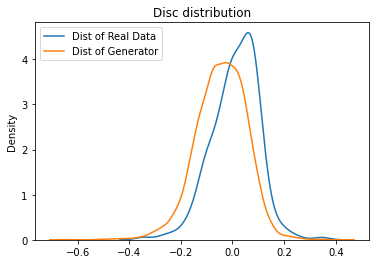

Epoch:2000, LossD/G:1.3546/-0.6839


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


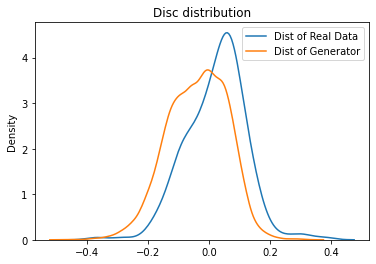

7
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142]
robust smallest singular value: 1.114938e-06
test smallest singular value: 0.00010434497503729902
Epoch:250, LossD/G:1.3805/-0.6843


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


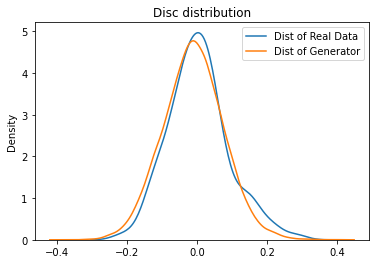

Epoch:500, LossD/G:1.4074/-0.7131


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


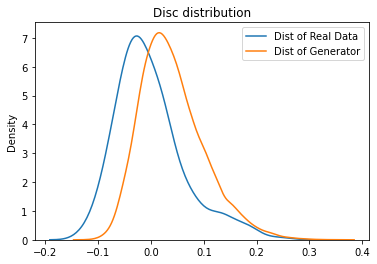

Epoch:750, LossD/G:1.3923/-0.6985


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


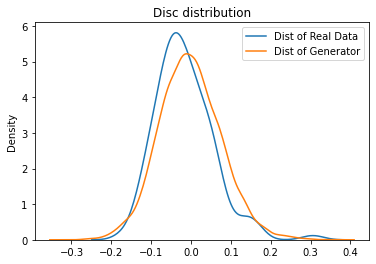

Epoch:1000, LossD/G:1.3843/-0.6743


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


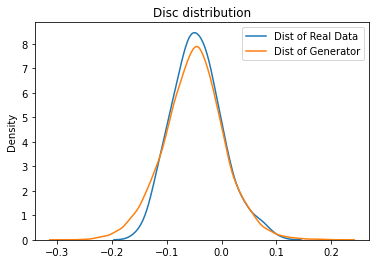

Epoch:1250, LossD/G:1.3861/-0.6858


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


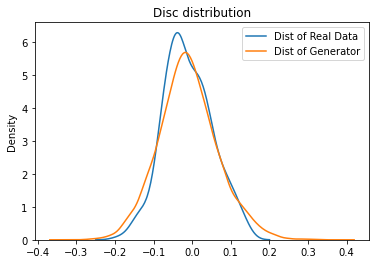

Epoch:1500, LossD/G:1.3814/-0.6734


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


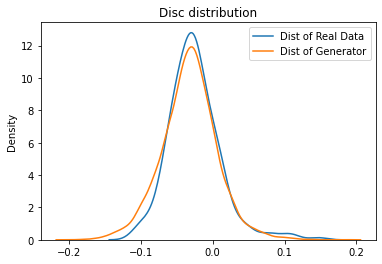

Epoch:1750, LossD/G:1.3752/-0.6652


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


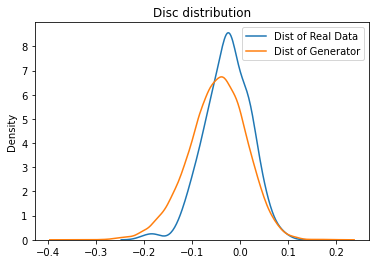

Epoch:2000, LossD/G:1.3822/-0.6797


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


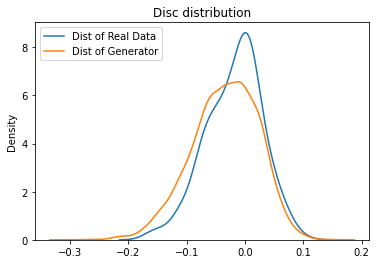

8
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547]
robust smallest singular value: 2.5982642e-06
test smallest singular value: 5.6374742145344005e-05
Epoch:250, LossD/G:1.3872/-0.7050


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


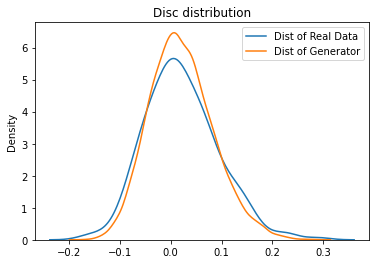

Epoch:500, LossD/G:1.3992/-0.7099


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


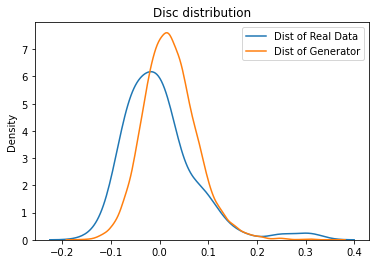

Epoch:750, LossD/G:1.3862/-0.6969


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


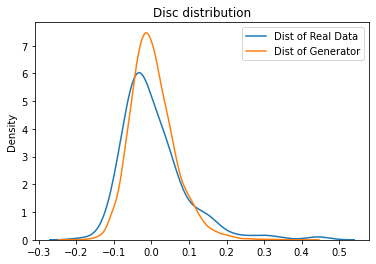

Epoch:1000, LossD/G:1.3797/-0.6803


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


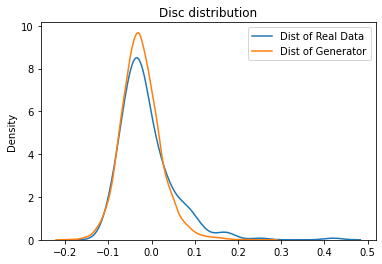

Epoch:1250, LossD/G:1.3769/-0.6783


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


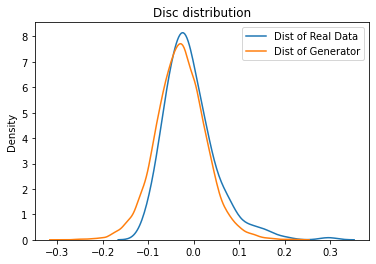

Epoch:1500, LossD/G:1.3646/-0.6754


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


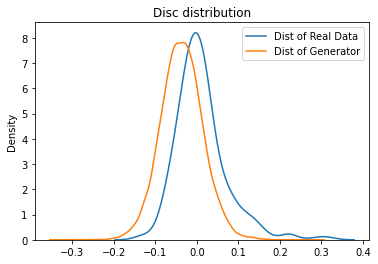

Epoch:1750, LossD/G:1.3665/-0.6749


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


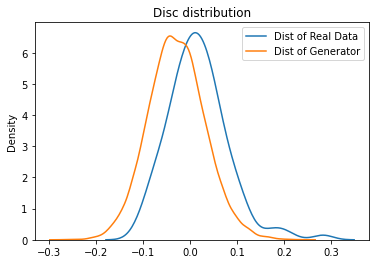

Epoch:2000, LossD/G:1.3598/-0.6763


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


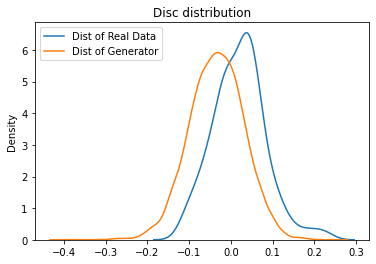

9
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256, 0.03661655749331159]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828, 0.006166649509845439]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547, 0.007865137733475308]
robust smallest singular value: 8.055817e-07
test smallest singular value: 3.515980089035377e-05
Epoch:250, LossD/G:1.3953/-0.7154


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


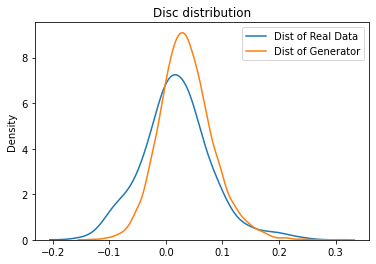

Epoch:500, LossD/G:1.4080/-0.7148


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


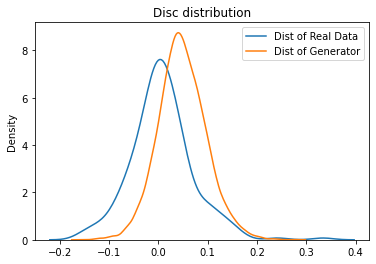

Epoch:750, LossD/G:1.3888/-0.6931


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


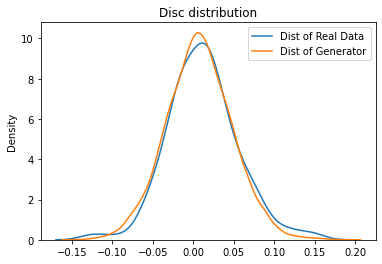

Epoch:1000, LossD/G:1.3892/-0.7072


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


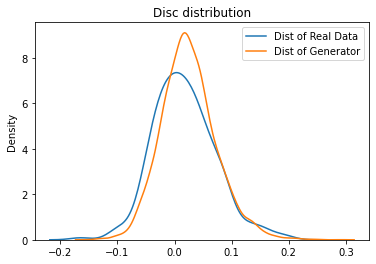

Epoch:1250, LossD/G:1.3782/-0.6934


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


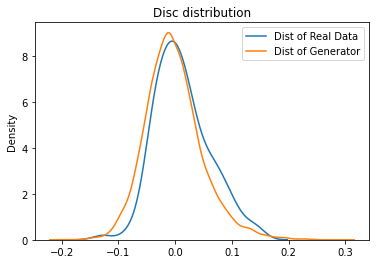

Epoch:1500, LossD/G:1.3810/-0.6848


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


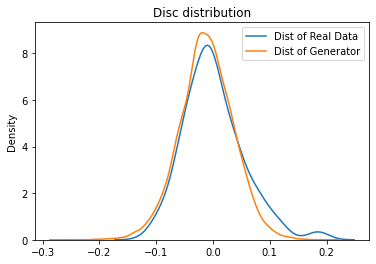

Epoch:1750, LossD/G:1.3730/-0.6783


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


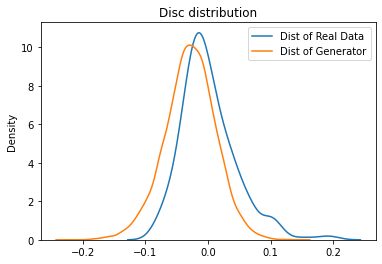

Epoch:2000, LossD/G:1.3732/-0.6881


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


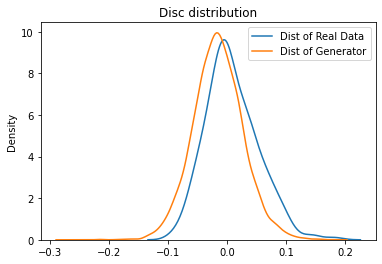

10
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256, 0.03661655749331159, 0.027922217514594474]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828, 0.006166649509845439, 0.0031738957004523263]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547, 0.007865137733475308, 0.005208116544473713]
robust smallest singular value: 3.4627726e-07
test smallest singular value: 1.4878122320380701e-05
Epoch:250, LossD/G:1.3977/-0.7139


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


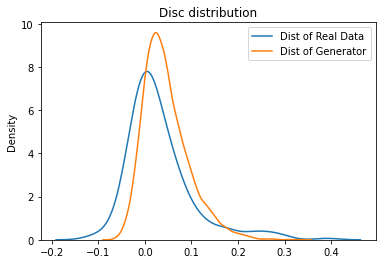

Epoch:500, LossD/G:1.3979/-0.7083


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


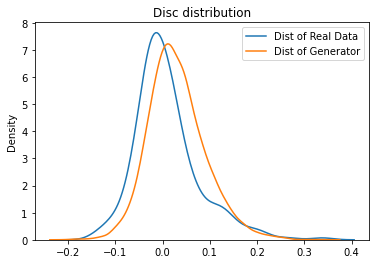

Epoch:750, LossD/G:1.3957/-0.7018


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


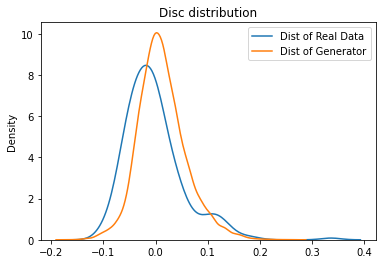

Epoch:1000, LossD/G:1.3811/-0.6972


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


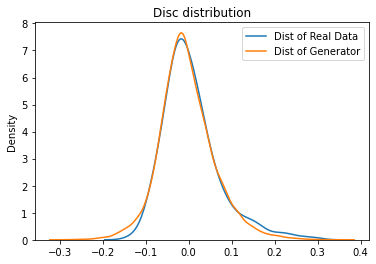

Epoch:1250, LossD/G:1.3907/-0.6888


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


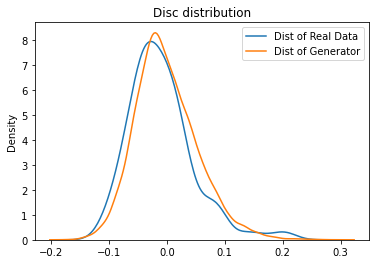

Epoch:1500, LossD/G:1.3826/-0.6723


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


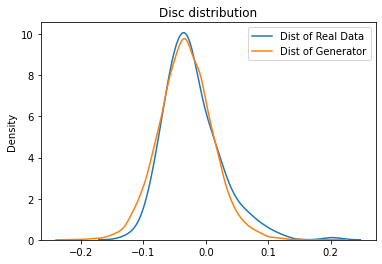

Epoch:1750, LossD/G:1.3806/-0.6747


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


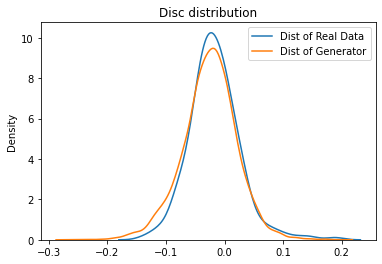

Epoch:2000, LossD/G:1.3816/-0.6895


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


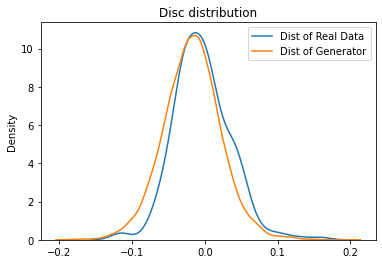

11
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256, 0.03661655749331159, 0.027922217514594474, 0.04207993742743024]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828, 0.006166649509845439, 0.0031738957004523263, 0.0032618684623923824]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547, 0.007865137733475308, 0.005208116544473713, 0.004680584118834881]
robust smallest singular value: 4.2117574e-07
test smallest singular value: 2.5114822870628828e-05
Epoch:250, LossD/G:1.3871/-0.7110


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


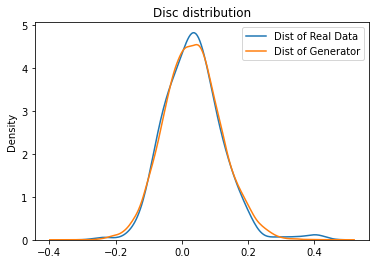

Epoch:500, LossD/G:1.3911/-0.6949


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


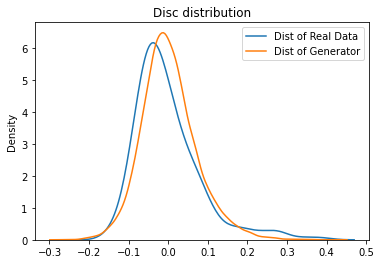

Epoch:750, LossD/G:1.3992/-0.6973


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


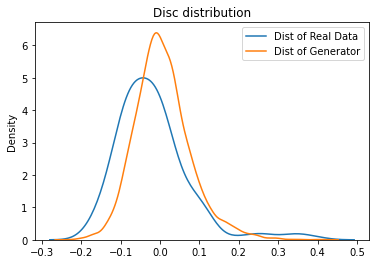

Epoch:1000, LossD/G:1.3854/-0.6769


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


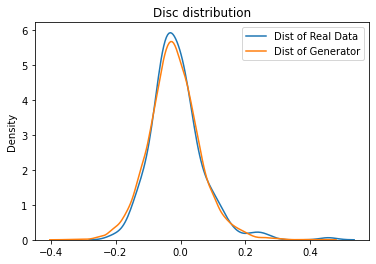

Epoch:1250, LossD/G:1.3729/-0.6774


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


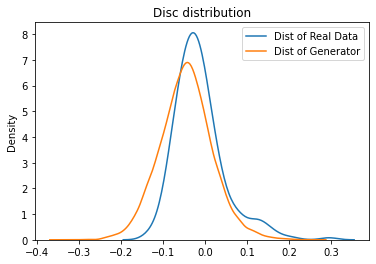

Epoch:1500, LossD/G:1.3763/-0.6732


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


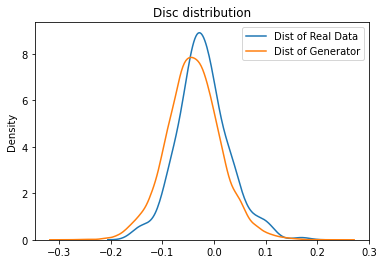

Epoch:1750, LossD/G:1.3638/-0.6745


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


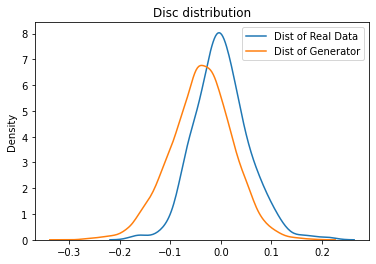

Epoch:2000, LossD/G:1.3579/-0.6671


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


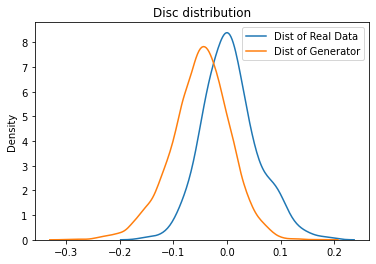

12
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256, 0.03661655749331159, 0.027922217514594474, 0.04207993742743024, 0.030062957195989535]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828, 0.006166649509845439, 0.0031738957004523263, 0.0032618684623923824, 0.006674158322812143]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547, 0.007865137733475308, 0.005208116544473713, 0.004680584118834881, 0.007514687309322255]
robust smallest singular value: 8.8117247e-07
test smallest singular value: 2.2182378710906038e-05
Epoch:250, LossD

/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


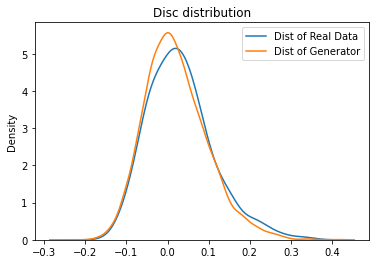

Epoch:500, LossD/G:1.4123/-0.7131


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


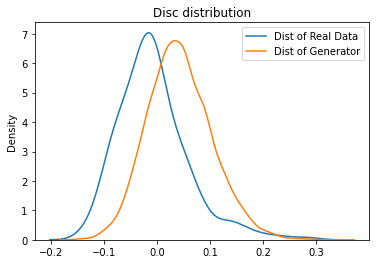

Epoch:750, LossD/G:1.3741/-0.6845


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


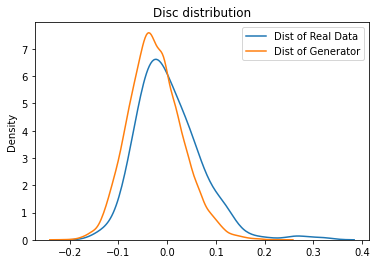

Epoch:1000, LossD/G:1.3958/-0.6935


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


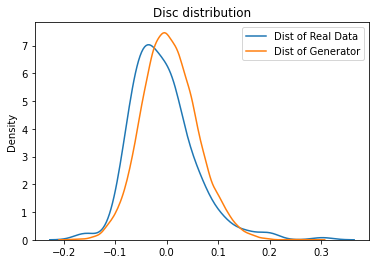

Epoch:1250, LossD/G:1.3658/-0.6785


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


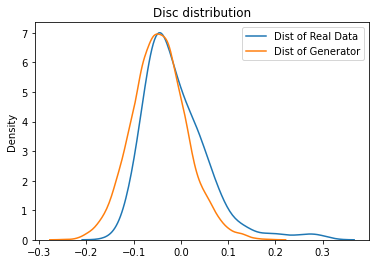

Epoch:1500, LossD/G:1.3818/-0.6854


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


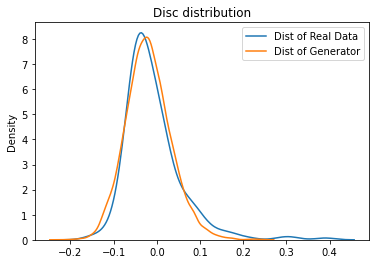

Epoch:1750, LossD/G:1.3597/-0.6634


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


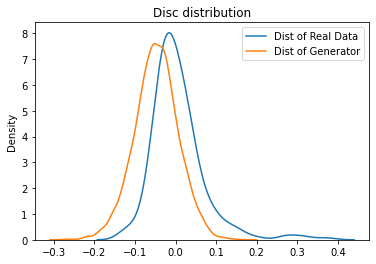

Epoch:2000, LossD/G:1.3740/-0.6780


/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zwz/anaconda/envs/shawn/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


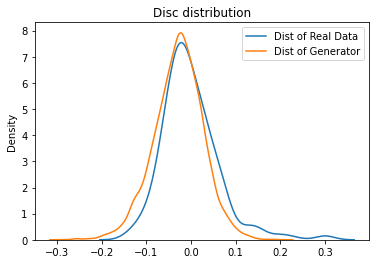

13
RISK: [0.029536766506364196, 0.01570223899727173, 0.013808507978778624, 0.026675563807008123, 0.02844180193880008, 0.03817161271544263, 0.050264956689760144, 0.06073036318931605, 0.021719452890276256, 0.03661655749331159, 0.027922217514594474, 0.04207993742743024, 0.030062957195989535, 0.050315448984097254]
SP_COVERR: [0.004708952993082814, 0.002229374901090403, 0.002835776929400628, 0.004737444014609467, 0.003676367264659108, 0.010456398068165769, 0.0209472260731128, 0.01447353523656541, 0.028227160011862828, 0.006166649509845439, 0.0031738957004523263, 0.0032618684623923824, 0.006674158322812143, 0.01946620071626674]
FRO_COVERR [0.007632223164894378, 0.003374177365473334, 0.004061166381786528, 0.005725687110458707, 0.0060014850709016205, 0.01235085316577192, 0.022057869040610276, 0.018155593069818142, 0.029042879059704547, 0.007865137733475308, 0.005208116544473713, 0.004680584118834881, 0.007514687309322255, 0.0204026375807448]
robust smallest singular value: 1.0992815e-06
test s

In [80]:
result_robust = backtest( ret_df, training_window=252, test_window=252, covfunc=robust_cov )

In [89]:
print("AVG Spectral Norm of the Prediction Error: {:.4f}({:.4f})(sample cov)/{:.4f}({:.4f})(robust)".format(
      np.mean( result_normal[2] ), np.std( result_normal[2] ), np.mean( result_robust[2] ), np.std(result_robust[2]) ))

AVG Spectral Norm of the Prediction Error: 0.0090(0.0077)(sample cov)/0.0094(0.0079)(robust)


In [90]:
print("AVG Frobenuis Norm of the Prediction Error: {:.4f}({:.4f})(sample cov)/{:.4f}({:.4f})(robust)".format(
      np.mean( result_normal[3] ), np.std( result_normal[3] ), np.mean( result_robust[3] ), np.std(result_robust[3]) ))

AVG Frobenuis Norm of the Prediction Error: 0.0101(0.0076)(sample cov)/0.0110(0.0078)(robust)


In [85]:
result_robust[2]

[0.004708952993082814,
 0.002229374901090403,
 0.002835776929400628,
 0.004737444014609467,
 0.003676367264659108,
 0.010456398068165769,
 0.0209472260731128,
 0.01447353523656541,
 0.028227160011862828,
 0.006166649509845439,
 0.0031738957004523263,
 0.0032618684623923824,
 0.006674158322812143,
 0.01946620071626674]

In [86]:
result_normal[2]

[0.0035368496314269506,
 0.003654576283856232,
 0.0023894601263624066,
 0.0044385842502321,
 0.002969719966981325,
 0.010366202727301889,
 0.020104578246814084,
 0.014297810285104098,
 0.026226316199045047,
 0.007210216816379573,
 0.002789528658489621,
 0.0022934149954983124,
 0.005810422376692484,
 0.020136521298670534]